## Dependencias

In [117]:
from pyspark import SparkContext
from pyspark.sql import SQLContext,SparkSession
from pyspark.sql import functions as F

import os
import subprocess
import numpy as np
import pandas as pd

import seaborn as sns

from functools import reduce
from datetime import date

import findspark

## Lectura de datos

In [118]:
df = pd.read_pickle('tad_aire.pkl')

In [119]:
df = df.loc[~df['y'].isnull()].reset_index(drop=True)
df.shape

(1715, 111)

In [120]:
df.head()

,ESTACION,ancla,CO_x_minimo_10,CO_x_maximo_10,CO_x_media_10,CO_x_desv_10,NO_x_minimo_10,NO_x_maximo_10,NO_x_media_10,NO_x_desv_10,...,PM25_x_desv_30,PMCO_x_minimo_30,PMCO_x_maximo_30,PMCO_x_media_30,PMCO_x_desv_30,SO2_x_minimo_30,SO2_x_maximo_30,SO2_x_media_30,SO2_x_desv_30,y
0,SAG,3977,0.0,2.0,0.418103,0.300389,1.0,178.0,14.831897,23.742709,...,13.210507,4.0,175.0,38.13093,19.44046,1.0,109.0,4.057803,6.807428,14.095238
1,FAR,3977,0.0,1.0,0.281435,0.185928,NaN,NaN,NaN,NaN,...,9.985451,NaN,NaN,NaN,NaN,0.0,46.0,2.893895,4.974938,21.857143
2,CCA,3977,0.0,1.0,0.259916,0.209410,0.0,69.0,5.455696,10.221443,...,8.750728,NaN,NaN,NaN,NaN,1.0,64.0,4.987124,7.552005,21.000000
3,MPA,3977,0.0,0.4,0.150427,0.118737,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,26.0,2.737518,3.058875,23.619048
4,VIF,3977,0.0,2.1,0.417797,0.375218,0.0,126.0,14.355932,23.787186,...,NaN,NaN,NaN,NaN,NaN,0.0,95.0,5.962963,10.884102,17.761905


## Definir variables

In [121]:
um = ['ESTACION','ancla']
var = sorted(df.filter(like='_x_').columns)
tgt = ['y']

## Ausentes

### Cuantificación de ausentes

In [122]:
miss = 1-df[var].describe().T[['count']]/len(df)
miss = miss.sort_values(by='count',ascending=False)
miss

,count
PMCO_x_minimo_10,0.629738
PMCO_x_desv_10,0.629738
PMCO_x_media_10,0.629738
PMCO_x_maximo_10,0.629738
PMCO_x_minimo_20,0.618076
...,...
O3_x_media_20,0.000000
O3_x_maximo_30,0.000000
O3_x_maximo_20,0.000000
O3_x_desv_30,0.000000


In [123]:
fuera = sorted(miss.loc[miss['count']>0.3].index)
var = [v for v in var if v not in fuera]
df.drop(fuera,axis=1,inplace=True)

In [124]:
df.head()

,ESTACION,ancla,CO_x_minimo_10,CO_x_maximo_10,CO_x_media_10,CO_x_desv_10,NO_x_minimo_10,NO_x_maximo_10,NO_x_media_10,NO_x_desv_10,...,NOX_x_desv_30,O3_x_minimo_30,O3_x_maximo_30,O3_x_media_30,O3_x_desv_30,SO2_x_minimo_30,SO2_x_maximo_30,SO2_x_media_30,SO2_x_desv_30,y
0,SAG,3977,0.0,2.0,0.418103,0.300389,1.0,178.0,14.831897,23.742709,...,30.165177,0.0,98.0,21.381503,20.675471,1.0,109.0,4.057803,6.807428,14.095238
1,FAR,3977,0.0,1.0,0.281435,0.185928,NaN,NaN,NaN,NaN,...,NaN,0.0,126.0,32.606557,29.442334,0.0,46.0,2.893895,4.974938,21.857143
2,CCA,3977,0.0,1.0,0.259916,0.209410,0.0,69.0,5.455696,10.221443,...,16.958058,1.0,159.0,35.177396,31.684286,1.0,64.0,4.987124,7.552005,21.000000
3,MPA,3977,0.0,0.4,0.150427,0.118737,NaN,NaN,NaN,NaN,...,NaN,2.0,143.0,43.834522,24.923506,0.0,26.0,2.737518,3.058875,23.619048
4,VIF,3977,0.0,2.1,0.417797,0.375218,0.0,126.0,14.355932,23.787186,...,31.135935,1.0,135.0,27.421652,25.656270,0.0,95.0,5.962963,10.884102,17.761905


### Imputación

In [125]:
from sklearn.impute import SimpleImputer
from scipy.stats import ks_2samp

In [126]:
X = df[var].copy()
im = SimpleImputer(strategy='mean')
im.fit(X)
Xi = pd.DataFrame(im.transform(X),columns=var)

In [127]:
Xi[um] = df[um]

In [128]:
Xi.dropna().shape,X.dropna().shape

((1715, 74), (1182, 72))

In [129]:
ks = pd.DataFrame(map(lambda v:(v,ks_2samp(Xi[v],X[v].dropna()).statistic),var),columns=['var','ks'])

In [130]:
rotas = sorted(ks.loc[ks['ks']>0.1]['var'])
rotas

['CO_x_minimo_20',
 'CO_x_minimo_30',
 'NOX_x_desv_10',
 'NOX_x_desv_20',
 'NOX_x_desv_30',
 'NOX_x_maximo_10',
 'NOX_x_maximo_20',
 'NOX_x_maximo_30',
 'NOX_x_media_10',
 'NOX_x_media_20',
 'NOX_x_media_30',
 'NOX_x_minimo_10',
 'NOX_x_minimo_20',
 'NOX_x_minimo_30',
 'NO_x_desv_10',
 'NO_x_desv_20',
 'NO_x_desv_30',
 'NO_x_maximo_10',
 'NO_x_maximo_20',
 'NO_x_maximo_30',
 'NO_x_media_10',
 'NO_x_media_20',
 'NO_x_media_30',
 'NO_x_minimo_10',
 'NO_x_minimo_20',
 'NO_x_minimo_30']

In [131]:
var = [v for v in var if v not in rotas]
len(var)

46

In [132]:
df.drop(rotas,axis=1,inplace=True)

In [133]:
X = df[var].copy()
im = SimpleImputer(strategy='mean')
im.fit(X)
Xi = pd.DataFrame(im.transform(X),columns=var)
Xi[um] = df[um]

In [134]:
Xi

,CO_x_desv_10,CO_x_desv_20,CO_x_desv_30,CO_x_maximo_10,CO_x_maximo_20,CO_x_maximo_30,CO_x_media_10,CO_x_media_20,CO_x_media_30,CO_x_minimo_10,...,SO2_x_maximo_20,SO2_x_maximo_30,SO2_x_media_10,SO2_x_media_20,SO2_x_media_30,SO2_x_minimo_10,SO2_x_minimo_20,SO2_x_minimo_30,ESTACION,ancla
0,0.300389,0.274292,0.295840,2.000000,2.00000,2.000000,0.418103,0.394181,0.402023,0.000000,...,20.000000,109.000000,2.629310,3.331897,4.057803,1.000000,1.000000,1.000000,SAG,3977
1,0.185928,0.177620,0.179038,1.000000,1.00000,1.000000,0.281435,0.264946,0.276385,0.000000,...,38.000000,46.000000,2.118143,2.391863,2.893895,0.000000,0.000000,0.000000,FAR,3977
2,0.209410,0.193501,0.198652,1.000000,1.00000,1.100000,0.259916,0.245591,0.248069,0.000000,...,64.000000,64.000000,3.109705,5.137634,4.987124,1.000000,1.000000,1.000000,CCA,3977
3,0.118737,0.117540,0.116600,0.400000,0.50000,0.600000,0.150427,0.172163,0.163909,0.000000,...,26.000000,26.000000,1.824786,2.657388,2.737518,0.000000,0.000000,0.000000,MPA,3977
4,0.375218,0.343540,0.339953,2.100000,2.10000,2.100000,0.417797,0.392735,0.422222,0.000000,...,66.000000,95.000000,3.830508,4.942308,5.962963,1.000000,0.000000,0.000000,VIF,3977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,0.355591,0.355502,0.342988,1.810000,2.07000,2.070000,0.484103,0.489784,0.492779,0.040000,...,61.000000,78.000000,3.923077,3.724359,3.880342,0.000000,0.000000,0.000000,FAC,4047
1711,0.320083,0.322712,0.320059,1.787677,1.96635,2.048284,0.435093,0.430744,0.423156,0.015716,...,46.806431,53.912989,3.747034,3.777653,3.883729,0.393939,0.325347,0.288146,GAM,4047
1712,0.422847,0.427152,0.424048,2.510000,2.51000,2.510000,0.667456,0.636258,0.609485,0.120000,...,42.000000,42.000000,4.308411,4.120000,3.916667,1.000000,0.000000,0.000000,MER,4047
1713,0.533611,0.498710,0.497499,3.020000,3.02000,3.350000,0.708711,0.658954,0.648696,0.070000,...,55.000000,55.000000,3.779736,3.227571,2.800872,0.000000,0.000000,0.000000,NEZ,4047


## Varianza cero

In [135]:
from sklearn.feature_selection import VarianceThreshold

In [136]:
vt = VarianceThreshold()

In [137]:
vt.fit(Xi[var])

VarianceThreshold()

In [138]:
fuera = [v for v,s in zip(var,vt.get_support()) if ~s]
fuera

[]

In [139]:
Xi.drop(fuera,axis=1,inplace=True)
var = [v for v in var if v not in fuera]

## Multicolinealidad

In [140]:
from varclushi import VarClusHi

In [141]:
vc = VarClusHi(df=Xi,feat_list=var)

In [142]:
vc.varclus()

In [143]:
rs = vc.rsquare

In [144]:
rs = rs.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)

In [145]:
rs['id'] = rs.groupby('Cluster').cumcount()+1
best = sorted(rs.loc[rs['id']==1]['Variable'])

In [146]:
best

['CO_x_desv_30',
 'NO2_x_desv_20',
 'NO2_x_minimo_20',
 'O3_x_desv_10',
 'O3_x_maximo_30',
 'O3_x_minimo_20',
 'SO2_x_desv_20',
 'SO2_x_minimo_20']

In [147]:
Xi = Xi[um+best].copy()

## Extremos

array([[<AxesSubplot:title={'center':'CO_x_desv_30'}>,
        <AxesSubplot:title={'center':'NO2_x_desv_20'}>,
        <AxesSubplot:title={'center':'NO2_x_minimo_20'}>],
       [<AxesSubplot:title={'center':'O3_x_desv_10'}>,
        <AxesSubplot:title={'center':'O3_x_maximo_30'}>,
        <AxesSubplot:title={'center':'O3_x_minimo_20'}>],
       [<AxesSubplot:title={'center':'SO2_x_desv_20'}>,
        <AxesSubplot:title={'center':'SO2_x_minimo_20'}>, <AxesSubplot:>]],
      dtype=object)

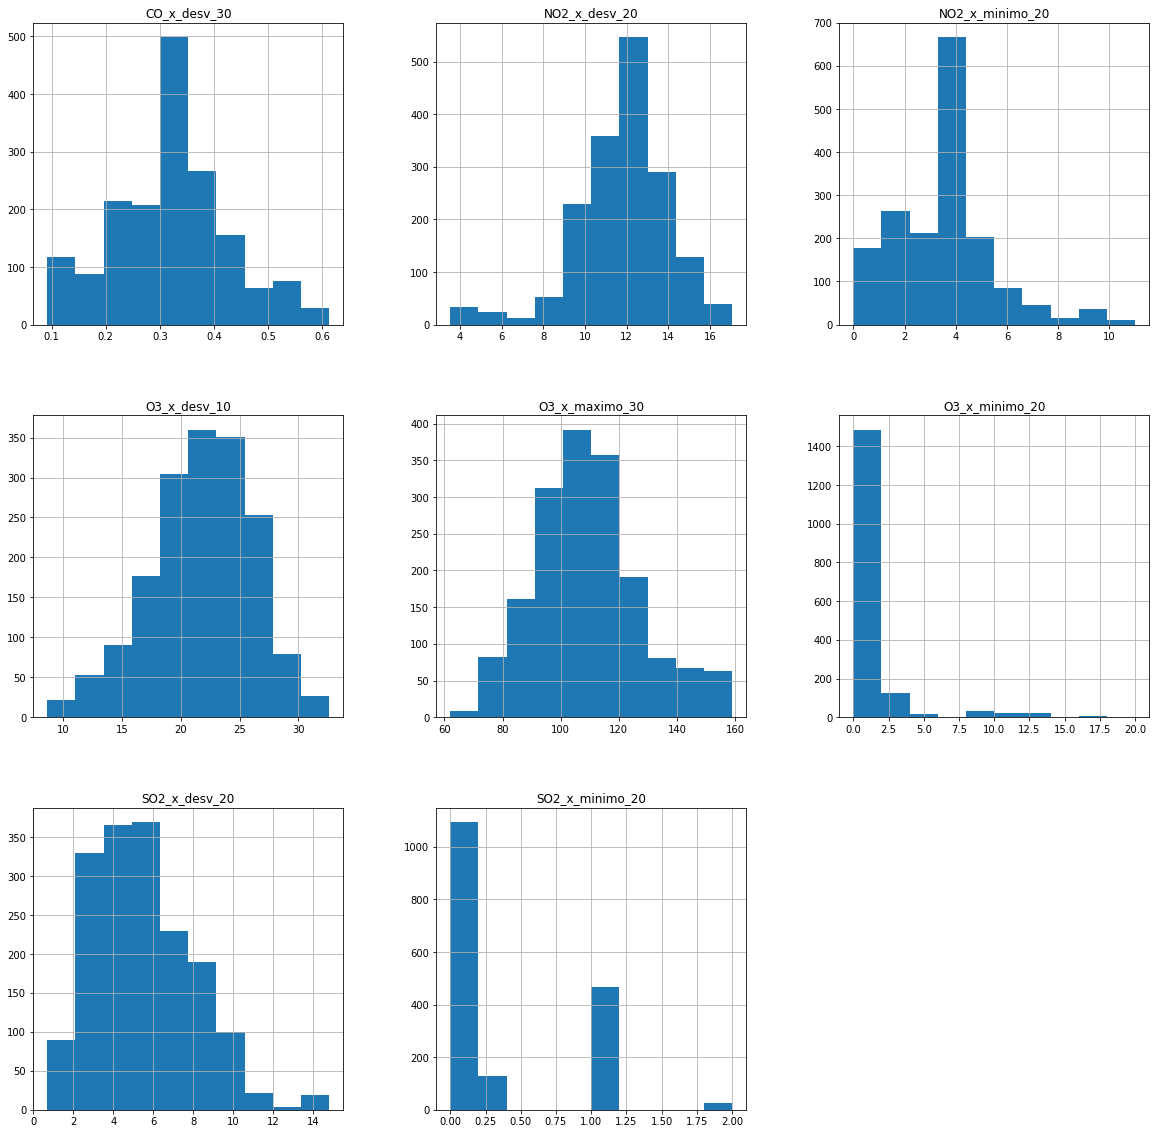

In [148]:
Xi[best].hist(figsize=(20,20))

In [149]:
for v,li,ls in Xi.describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)

In [150]:
Xi['ex_'] = Xi.filter(like='ex_').max(axis=1)

In [151]:
Xi['ex_'].value_counts(True)

0    0.897376
1    0.102624
Name: ex_, dtype: float64

In [152]:
Xi = Xi.loc[Xi['ex_']==0].drop(Xi.filter(like='ex_').columns,axis=1)

array([[<AxesSubplot:title={'center':'CO_x_desv_30'}>,
        <AxesSubplot:title={'center':'NO2_x_desv_20'}>,
        <AxesSubplot:title={'center':'NO2_x_minimo_20'}>],
       [<AxesSubplot:title={'center':'O3_x_desv_10'}>,
        <AxesSubplot:title={'center':'O3_x_maximo_30'}>,
        <AxesSubplot:title={'center':'O3_x_minimo_20'}>],
       [<AxesSubplot:title={'center':'SO2_x_desv_20'}>,
        <AxesSubplot:title={'center':'SO2_x_minimo_20'}>, <AxesSubplot:>]],
      dtype=object)

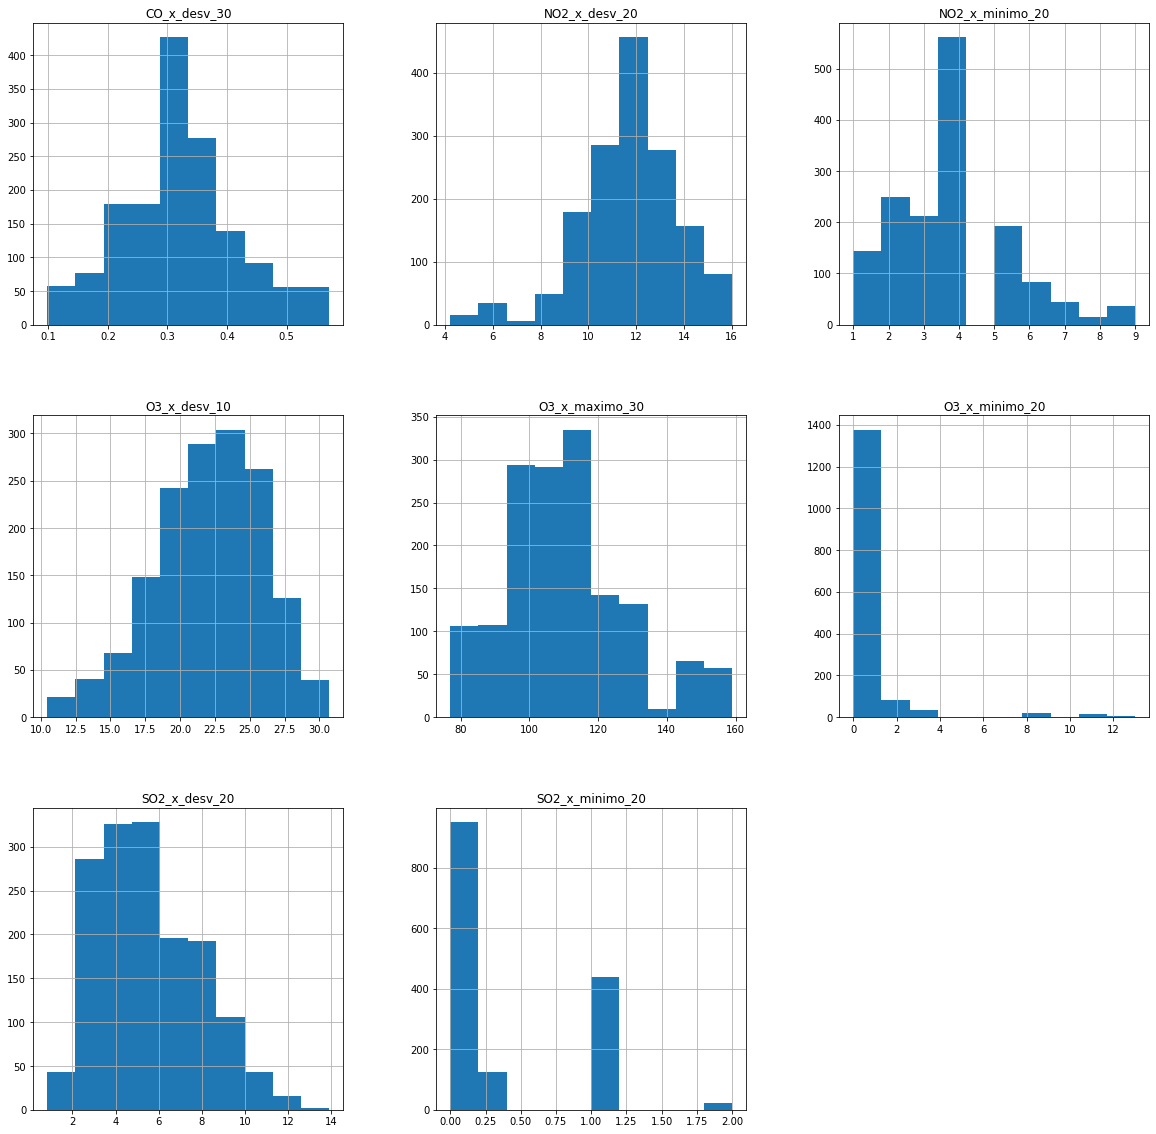

In [153]:
Xi[best].hist(figsize=(20,20))

In [154]:
Xi

,ESTACION,ancla,CO_x_desv_30,NO2_x_desv_20,NO2_x_minimo_20,O3_x_desv_10,O3_x_maximo_30,O3_x_minimo_20,SO2_x_desv_20,SO2_x_minimo_20
0,SAG,3977,0.295840,10.953312,3.000000,20.194397,98.0,0.0,3.281892,1.000000
1,FAR,3977,0.179038,10.092397,3.000000,26.466144,126.0,3.0,3.901493,0.000000
3,MPA,3977,0.116600,6.386824,2.000000,25.786807,143.0,2.0,3.133367,0.000000
4,VIF,3977,0.339953,12.681366,2.000000,23.581905,135.0,1.0,8.427477,0.000000
5,SFE,3977,0.214530,13.208669,4.000000,30.332578,151.0,1.0,6.215837,1.000000
...,...,...,...,...,...,...,...,...,...,...
1710,FAC,4047,0.342988,13.578063,2.000000,24.233090,115.0,2.0,6.477674,0.000000
1711,GAM,4047,0.320059,13.362312,4.000000,27.676218,101.0,0.0,5.486840,0.325347
1712,MER,4047,0.424048,13.589167,9.000000,27.308180,107.0,0.0,5.623590,0.000000
1713,NEZ,4047,0.497499,12.458613,6.000000,25.680166,99.0,1.0,6.233106,0.000000


In [155]:
tad = Xi.merge(df[um+tgt],on=um,how='inner')

In [156]:
tad.head()

,ESTACION,ancla,CO_x_desv_30,NO2_x_desv_20,NO2_x_minimo_20,O3_x_desv_10,O3_x_maximo_30,O3_x_minimo_20,SO2_x_desv_20,SO2_x_minimo_20,y
0,SAG,3977,0.295840,10.953312,3.0,20.194397,98.0,0.0,3.281892,1.0,14.095238
1,FAR,3977,0.179038,10.092397,3.0,26.466144,126.0,3.0,3.901493,0.0,21.857143
2,MPA,3977,0.116600,6.386824,2.0,25.786807,143.0,2.0,3.133367,0.0,23.619048
3,VIF,3977,0.339953,12.681366,2.0,23.581905,135.0,1.0,8.427477,0.0,17.761905
4,SFE,3977,0.214530,13.208669,4.0,30.332578,151.0,1.0,6.215837,1.0,22.666667


## Regresión Lineal

In [157]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [158]:
Xt,Xv = train_test_split(tad,train_size=0.7)

In [159]:
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)

In [160]:
mod = LinearRegression()

In [161]:
mod.fit(Xt[best],Xt[tgt])

LinearRegression()

In [162]:
print(mean_absolute_error(y_pred=mod.predict(Xt[best]),y_true=Xt[tgt]))
print(mean_absolute_error(y_pred=mod.predict(Xv[best]),y_true=Xv[tgt]))

5.475177145360914
5.156807582757975


<AxesSubplot:ylabel='Density'>

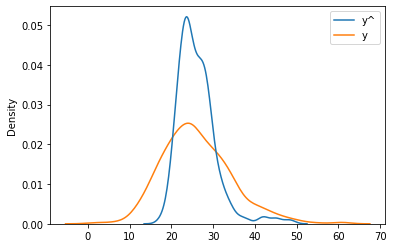

In [163]:
sns.kdeplot(data=pd.DataFrame({'y^':list(mod.predict(Xt[best]).reshape(1,-1)[0]),
              'y':list(np.array(Xt[tgt]).reshape(1,-1)[0])}),cumulative=False)

<AxesSubplot:ylabel='Density'>

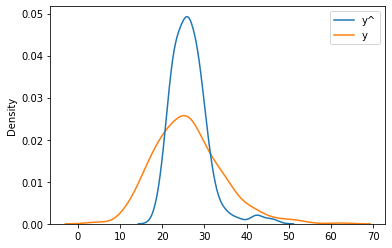

In [164]:
sns.kdeplot(data=pd.DataFrame({'y^':list(mod.predict(Xv[best]).reshape(1,-1)[0]),
              'y':list(np.array(Xv[tgt]).reshape(1,-1)[0])}),cumulative=False)

In [165]:
mod.coef_,mod.intercept_

(array([[-8.20628089, -0.91499908,  0.45086111,  0.4286594 ,  0.03284174,
          1.36539836, -0.42426494, -2.37380835]]),
 array([26.93698727]))

In [166]:
Xt.to_pickle('Xt.pkl') 
Xv.to_pickle('Xv.pkl') 